C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 1056        batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 0/10000, Loss: -0.0373, Loss: -0.2059, Time: 18.07s


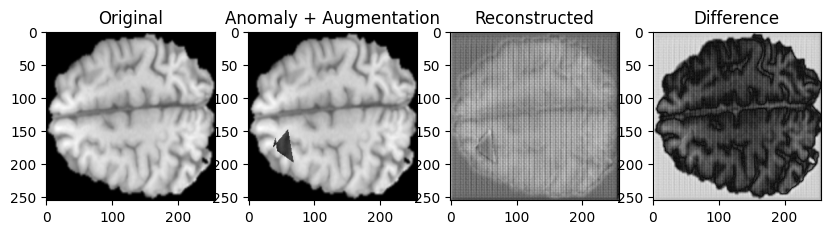

Epoch 10/10000, Loss: -0.0956, Loss: -0.2475, Time: 4.06s


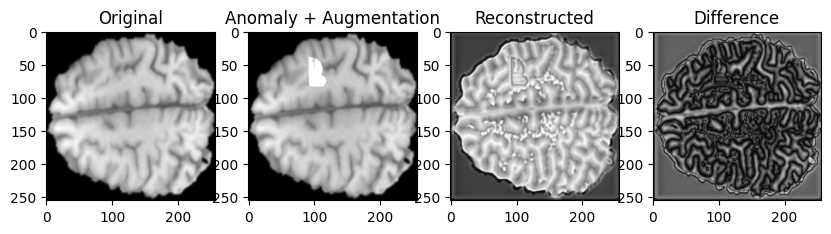

Epoch 20/10000, Loss: -0.1023, Loss: -0.2537, Time: 4.18s


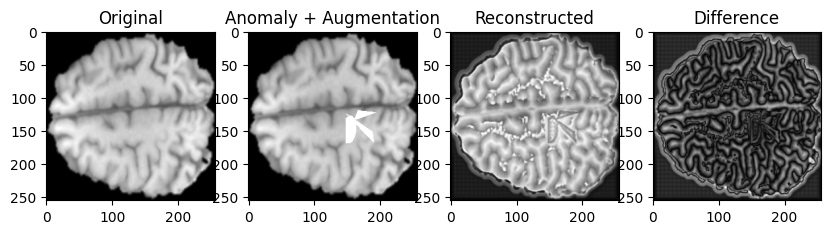

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.image import ssim
from tensorflow.image import ssim, psnr


# Attention block
def attention_block(input_tensor, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid')(input_tensor)
    return layers.multiply([input_tensor, attention])

# Encoder block
def encoder_block(input_tensor, filters, use_attention=False):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    if use_attention:
        x = attention_block(x, filters)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skip = x
    x = layers.MaxPooling2D((2, 2))(x)
    return x, skip

# Decoder block
def decoder_block(input_tensor, skip_tensor, filters, use_attention=False):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, skip_tensor])
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    if use_attention:
        x = attention_block(x, filters)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

# U-Net model with attention
def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1, skip1 = encoder_block(inputs, 32, use_attention=True)
    x2, skip2 = encoder_block(x1, 64, use_attention=True)
    x3, skip3 = encoder_block(x2, 128, use_attention=True)
    x4, skip4 = encoder_block(x3, 256, use_attention=True)

    
    # Bottleneck
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dropout(0.3)(bottleneck)

    # Decoder
    x = decoder_block(bottleneck, skip4, 256, use_attention=False)
    x = decoder_block(x, skip3, 128, use_attention=False)
    x = decoder_block(x, skip2, 64, use_attention=False)
    x = decoder_block(x, skip1, 32, use_attention=False)

    # Output layer (Reconstructed Image)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

#Custom loss with more weight on the anomaly region
def combined_loss_with_anomaly_weight(original, anomaly_weight=5.0):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
        
        # Weight anomaly region more
        anomaly_region = tf.abs(y_true - y_pred) > 0.3  # Detect significant differences (anomalies)
        weighted_mse_loss = tf.reduce_mean(anomaly_weight * tf.square(y_true - y_pred) * tf.cast(anomaly_region, tf.float32))
        
        return mse_loss + (1 - tf.reduce_mean(ssim_loss)) + weighted_mse_loss
    return loss

# def combined_loss_with_anomaly_weight(original, anomaly_weight=5.0):
#     def loss(y_true, y_pred):
#         # Ensure the predicted output is resized to match y_true
#         y_pred_resized = y_pred
        
#         print(f"Shape of y_true: {y_true.shape}")
#         print(f"Shape of y_pred_resized: {y_pred_resized.shape}")

#         # Calculate PSNR loss
#         psnr_loss = -tf.reduce_mean(psnr(y_true, y_pred_resized, max_val=1.0))  # PSNR returns large values for better matches, hence negate
        
#         # SSIM loss
#         ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred_resized, max_val=1.0))

#         # Weight anomaly region more
#         anomaly_region = tf.abs(y_true - y_pred_resized) > 0.3
#         weighted_psnr_loss = -tf.reduce_mean(anomaly_weight * psnr(y_true, y_pred_resized, max_val=1.0) * tf.cast(anomaly_region, tf.float32))

#         # Combine losses
#         return  psnr_loss + ssim_loss + weighted_psnr_loss
    
#     return loss

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

def inject_anomaly(image, window_size=60):
    h, w = image.shape[:2]
    x, y = np.random.randint(0, h - window_size), np.random.randint(0, w - window_size)
    anomaly_window = image[x:x+window_size, y:y+window_size]
    
    anomaly_window = A.RandomBrightnessContrast(p=0.7, brightness_limit=(-.4,0.4), contrast_limit=(-0.6,0.6))(image=anomaly_window)["image"]
    anomaly_window = A.ElasticTransform(p=0.7, alpha=50, sigma=50)(image=anomaly_window)["image"]
    
    mask = np.zeros_like(anomaly_window, dtype=np.uint8)
    num_shapes = np.random.randint(1, 4)
    
    for _ in range(num_shapes):
        shape_type = np.random.choice(['ellipse', 'polygon'])
        if shape_type == 'ellipse':
            center = (np.random.randint(0, window_size), np.random.randint(0, window_size))
            axes = (np.random.randint(10, window_size // 2), np.random.randint(10, window_size // 2))
            angle = np.random.randint(0, 180)
            cv2.ellipse(mask, center, axes, angle, 0, 360, (255, 255, 255), -1)
        elif shape_type == 'polygon':
            num_points = np.random.randint(3, 7)
            points = np.array([[
                (np.random.randint(0, window_size), np.random.randint(0, window_size))
                for _ in range(num_points)
            ]], dtype=np.int32)
            cv2.fillPoly(mask, points, (255, 255, 255))
    
    masked_anomaly = cv2.bitwise_and(anomaly_window, anomaly_window, mask=mask)
    anomaly_image = image.copy()
    new_x, new_y = np.random.randint(0, h - window_size), np.random.randint(0, w - window_size)
    window_region = anomaly_image[new_x:new_x+window_size, new_y:new_y+window_size]
    np.copyto(window_region, masked_anomaly, where=mask.astype(bool))

    return anomaly_image, masked_anomaly
# Albumentations augmentation
def augment_image(image):
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image[..., 0]

    image = (image * 255).astype(np.uint8)
    transform = A.Compose([
        #A.AdvancedBlur(p=0.5),
        #A.CLAHE(p=0.5),
        #A.Downscale(p=0.5),
        #A.Emboss(p=0.5),
        #A.Equalize(p=0.5),
        #A.FancyPCA(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.CoarseDropout(p=0.5),
        #A.PixelDropout(p=0.5)
    ])
    augmented = transform(image=image)
    return augmented['image'] / 255.0

# Load dataset from PNG images
def load_slices_from_png(folder_path):
    all_slices = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = img / 255.0  # Normalize to [0,1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension (128, 128, 1)
            all_slices.append(img)
    return np.array(all_slices)

folder_path = r"cropped"  # Update path
slices = load_slices_from_png(folder_path)

# Resize to (128, 128) if needed
slices = [smart_resize(slice_img, (256, 256)) for slice_img in slices]
slices = np.array(slices)

# Build the U-Net model for 128x128 images
unet_model = build_unet(input_shape=(256, 256, 1))

# Compile with custom loss (more weight on anomaly region)
unet_model.compile(optimizer='adam', 
                   loss=combined_loss_with_anomaly_weight(original=slices[0], anomaly_weight=5.0), 
                   metrics=[ssim_metric])

epochs = 10000
batch_size = 32

unet_model.summary()
# Training loop
for epoch in range(epochs + 1):
    start_time = time.time()

    for slice_img in slices:
        original_img = slice_img.copy()
        
        if epoch % 10 == 0:
            anomaly_img, anomaly_mask = inject_anomaly(np.squeeze(slice_img))
        else:
            anomaly_img = slice_img
        
        anomaly_img = np.expand_dims(np.squeeze(anomaly_img), axis=-1)  # Ensure channel dimension
        augmented_img = augment_image(anomaly_img)
        augmented_img = np.expand_dims(augmented_img, axis=0)  # Add batch dimension

        original_img = np.expand_dims(original_img, axis=-1)
        original_img = np.expand_dims(original_img, axis=0)

        # Train the model
        loss_value = unet_model.train_on_batch(augmented_img, original_img)
        
    epoch_time = time.time() - start_time

    if epoch % 100 == 0:
        unet_model.save(f'unet_model_epoch_{epoch}.h5')


    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss_value[0]:.4f}, Loss: {loss_value[1]:.4f}, Time: {epoch_time:.2f}s")
        plt.figure(figsize=(10, 5)) 
        plt.subplot(1, 4, 1) 
        plt.imshow(np.squeeze(original_img), cmap='gray') 
        plt.title("Original") 
        plt.subplot(1, 4, 2) 
        plt.imshow(np.squeeze(augmented_img), cmap='gray') 
        plt.title("Anomaly + Augmentation") 
        plt.subplot(1, 4, 3) 
        reconstructed_img = unet_model.predict(augmented_img) 
        plt.imshow(np.squeeze(reconstructed_img), cmap='gray') 
        plt.title("Reconstructed") 
        plt.subplot(1, 4, 4) 
        diff = np.abs(np.squeeze(original_img) - np.squeeze(reconstructed_img)) 
        plt.imshow(diff, cmap='gray') 
        plt.title("Difference") 
        plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))  # MSE error per image

# Function to classify as anomalous based on a threshold
def classify_anomalies(reconstruction_error, threshold):
    return reconstruction_error > threshold

# Load test images (assuming grayscale 512x512 MRI images)
def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Define a function to evaluate model performance and show reconstructed images
def evaluate_model_and_display(vae, test_images, true_labels, threshold):
    reconstruction_errors = []
    predictions = []
    
    for img in test_images:
        original = img
        reconstructed = unet_model.predict(img)  # Predict reconstructed image
        error = calculate_reconstruction_error(original, reconstructed)
        reconstruction_errors.append(error)
        predictions.append(classify_anomalies(error, threshold))
    
        # Display original and reconstructed images
        plt.figure(figsize=(10, 5))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(original), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Reconstructed image
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(reconstructed), cmap='gray')
        if classify_anomalies(error, threshold):
            plt.title("Reconstructed Image (Anomalous)")
        else:
            plt.title("Reconstructed Image (Normal)")
        plt.axis("off")
        
        plt.show()
    
    reconstruction_errors = np.array(reconstruction_errors)
    predictions = np.array(predictions)

    # Calculate evaluation metrics
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, reconstruction_errors)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")

    return predictions, reconstruction_errors

# Example usage
test_image_paths = ['test/processed_image_edit.png',r"C:\Users\priya\Documents\DL project\test 2\processed_image_edit.png",r"C:\Users\priya\Documents\DL project\test 3\processed_image_edit.png"]  # Replace with actual image paths
test_images = [load_image(path) for path in test_image_paths]
true_labels = [1, 0, 0]  # Ground truth labels (0 = normal, 1 = anomalous)

  # Replace with the correct path

# Set an anomaly threshold
anomaly_threshold = 0.05  # You can tune this based on your validation results

# Evaluate the model and display reconstructed images
predictions, reconstruction_errors = evaluate_model_and_display(unet_model, test_images, true_labels, anomaly_threshold)

# Plot the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, label="Reconstruction Errors")
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.show()


C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 0/10000, Loss: -0.0179, Loss: -0.1950, Time: 23.95s


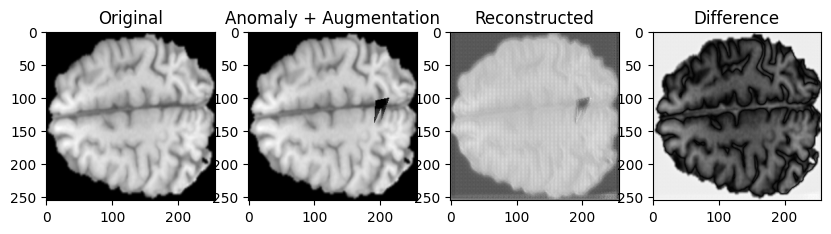

Epoch 10/10000, Loss: -0.0596, Loss: -0.2324, Time: 5.99s


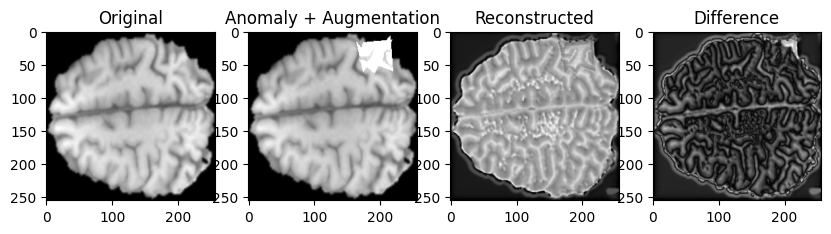

Epoch 20/10000, Loss: -0.0978, Loss: -0.2493, Time: 5.98s


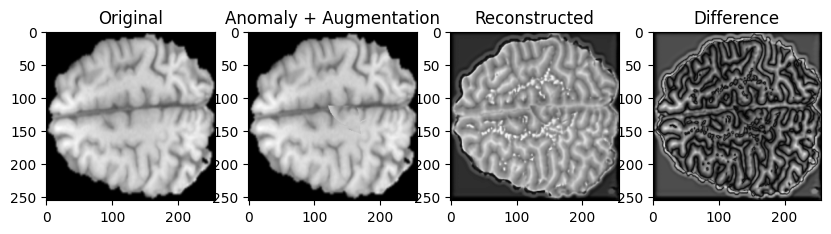

Epoch 30/10000, Loss: -0.0903, Loss: -0.2427, Time: 5.99s


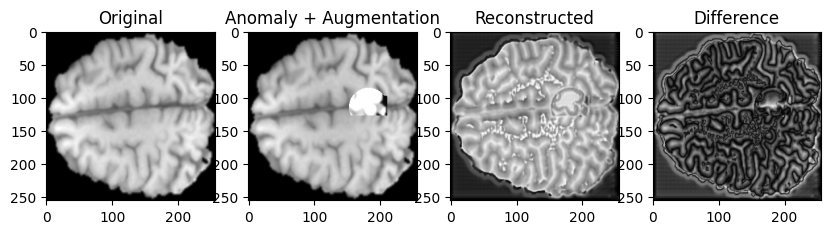

Epoch 40/10000, Loss: -0.0863, Loss: -0.2430, Time: 5.95s


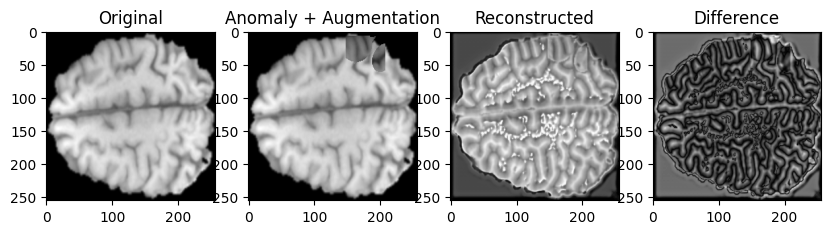

Epoch 50/10000, Loss: -0.0907, Loss: -0.2473, Time: 6.06s


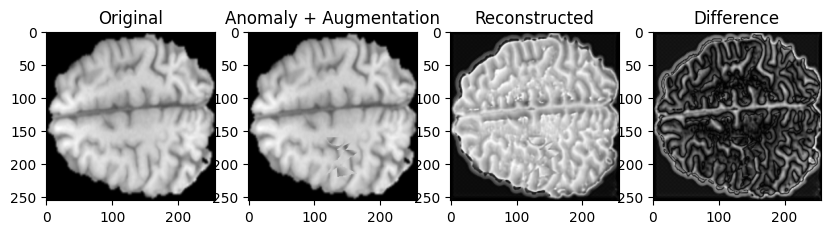

Epoch 60/10000, Loss: -0.0757, Loss: -0.2493, Time: 6.03s


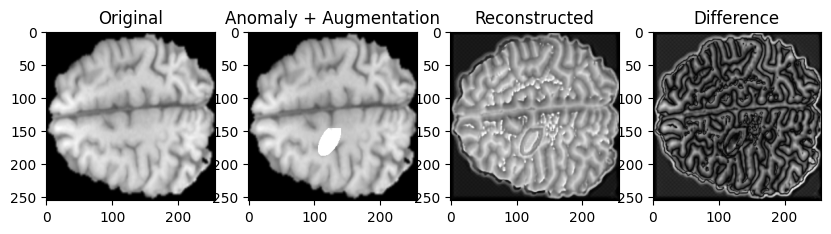

Epoch 70/10000, Loss: -0.0929, Loss: -0.2522, Time: 6.38s


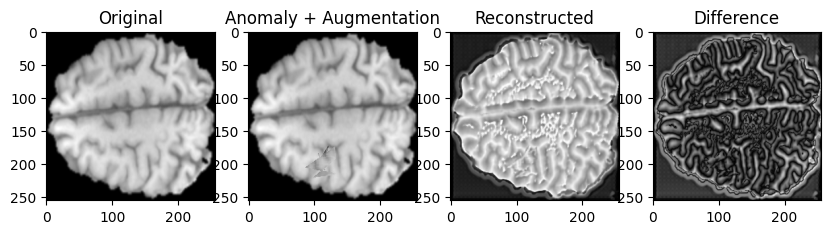

Epoch 80/10000, Loss: -0.0663, Loss: -0.2546, Time: 5.99s


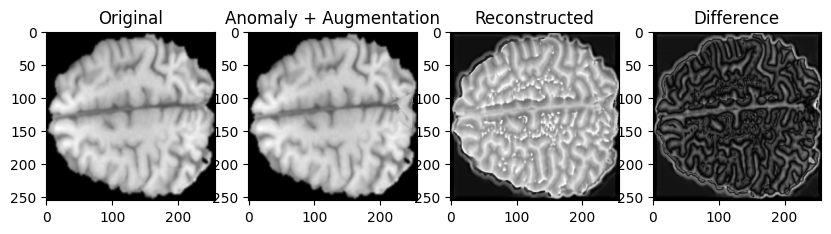

Epoch 90/10000, Loss: -0.0495, Loss: -0.2535, Time: 6.11s


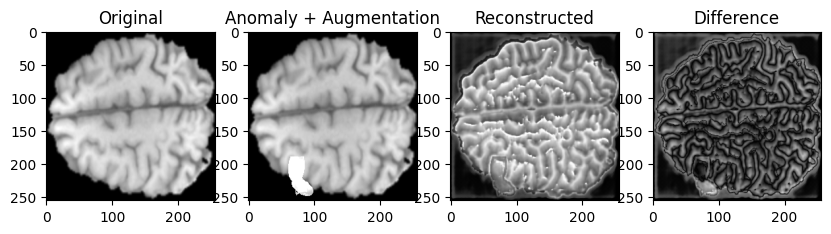

C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 100/10000, Loss: -0.0576, Loss: -0.2483, Time: 6.09s


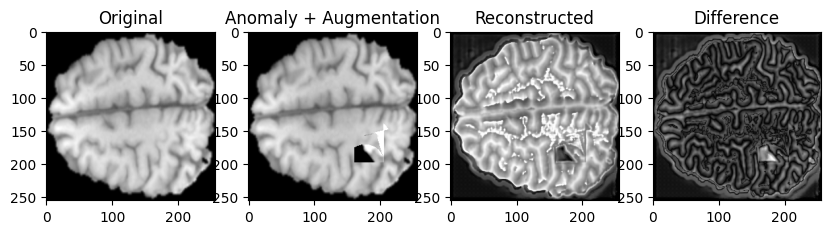

Epoch 110/10000, Loss: -0.0753, Loss: -0.2586, Time: 6.07s


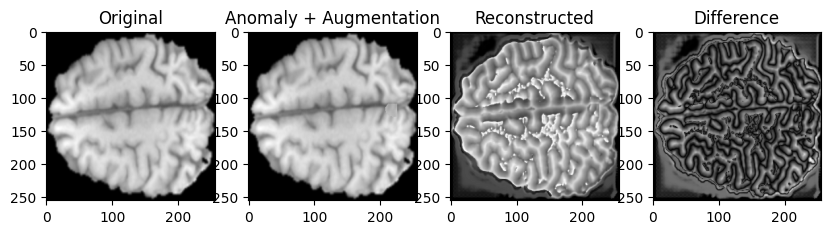

Epoch 120/10000, Loss: -0.1037, Loss: -0.2560, Time: 6.10s


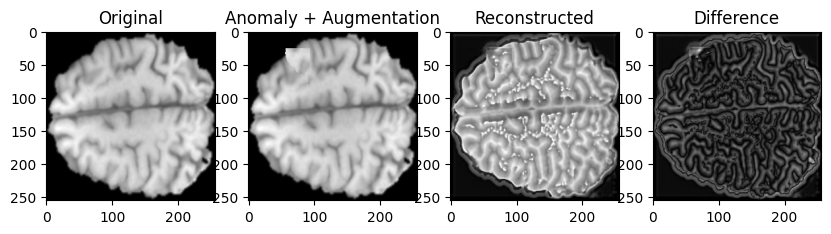

Epoch 130/10000, Loss: -0.0887, Loss: -0.2505, Time: 6.09s


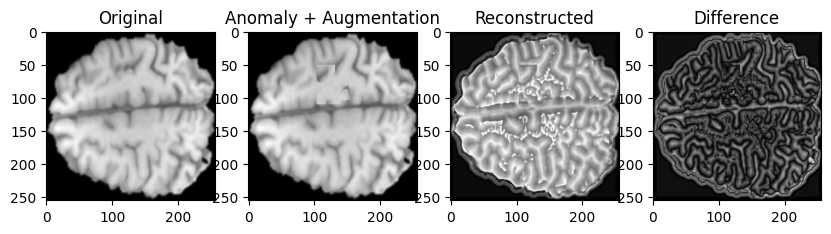

Epoch 140/10000, Loss: -0.1206, Loss: -0.2552, Time: 6.00s


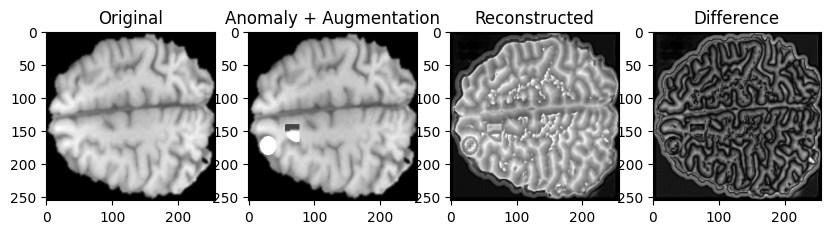

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.image import ssim
from tensorflow.image import ssim, psnr


from tensorflow.keras import layers

# Attention Block (Channel + Spatial Attention)
def attention_block(input_tensor, filters):
    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    avg_pool = layers.Reshape((1, 1, filters))(avg_pool)
    avg_pool = layers.Dense(filters // 8, activation='relu')(avg_pool)
    avg_pool = layers.Dense(filters, activation='sigmoid')(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    max_pool = layers.Reshape((1, 1, filters))(max_pool)
    max_pool = layers.Dense(filters // 8, activation='relu')(max_pool)
    max_pool = layers.Dense(filters, activation='sigmoid')(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Multiply()([input_tensor, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
    concat_spatial = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat_spatial)

    attention_output = layers.Multiply()([channel_attention, spatial_attention])

    return attention_output


# Encoder block
import tensorflow as tf
from tensorflow.keras import layers, models

# Encoder block with optional attention
def encoder_block(input_tensor, filters, use_attention=False):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    if use_attention:
        x = attention_block(x, filters)  # Use new attention block
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skip = x
    x = layers.MaxPooling2D((2, 2))(x)
    return x, skip

# Decoder block with optional attention
def decoder_block(input_tensor, skip_tensor, filters, use_attention=False):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, skip_tensor])
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    if use_attention:
        x = attention_block(x, filters)  # Use new attention block
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

# U-Net model with attention
def build_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1, skip1 = encoder_block(inputs, 32, use_attention=True)
    x2, skip2 = encoder_block(x1, 64, use_attention=True)
    x3, skip3 = encoder_block(x2, 128, use_attention=True)
    x4, skip4 = encoder_block(x3, 256, use_attention=False)
    x5, skip5 = encoder_block(x4, 512, use_attention=False)
    
    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x5)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dropout(0.3)(bottleneck)

    # Decoder
    x = decoder_block(bottleneck, skip5, 512, use_attention=False)
    x = decoder_block(x, skip4, 256, use_attention=False)
    x = decoder_block(x, skip3, 128, use_attention=True)
    x = decoder_block(x, skip2, 64, use_attention=True)
    x = decoder_block(x, skip1, 32, use_attention=True)

    # Output layer (Reconstructed Image)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# Build the model
unet_model = build_unet(input_shape=(256, 256, 1))
unet_model.summary()


#Custom loss with more weight on the anomaly region
def combined_loss_with_anomaly_weight(original, anomaly_weight=5.0):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
        
        # Weight anomaly region more
        anomaly_region = tf.abs(y_true - y_pred) > 0.3  # Detect significant differences (anomalies)
        weighted_mse_loss = tf.reduce_mean(anomaly_weight * tf.square(y_true - y_pred) * tf.cast(anomaly_region, tf.float32))
        
        return mse_loss + (1 - tf.reduce_mean(ssim_loss)) + weighted_mse_loss
    return loss

# def combined_loss_with_anomaly_weight(original, anomaly_weight=5.0):
#     def loss(y_true, y_pred):
#         # Ensure the predicted output is resized to match y_true
#         y_pred_resized = y_pred
        
#         print(f"Shape of y_true: {y_true.shape}")
#         print(f"Shape of y_pred_resized: {y_pred_resized.shape}")

#         # Calculate PSNR loss
#         psnr_loss = -tf.reduce_mean(psnr(y_true, y_pred_resized, max_val=1.0))  # PSNR returns large values for better matches, hence negate
        
#         # SSIM loss
#         ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred_resized, max_val=1.0))

#         # Weight anomaly region more
#         anomaly_region = tf.abs(y_true - y_pred_resized) > 0.3
#         weighted_psnr_loss = -tf.reduce_mean(anomaly_weight * psnr(y_true, y_pred_resized, max_val=1.0) * tf.cast(anomaly_region, tf.float32))

#         # Combine losses
#         return  psnr_loss + ssim_loss + weighted_psnr_loss
    
#     return loss

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

def inject_anomaly(image, window_size=60):
    h, w = image.shape[:2]
    x, y = np.random.randint(0, h - window_size), np.random.randint(0, w - window_size)
    anomaly_window = image[x:x+window_size, y:y+window_size]
    
    anomaly_window = A.RandomBrightnessContrast(p=0.7, brightness_limit=(-.4,0.4), contrast_limit=(-0.6,0.6))(image=anomaly_window)["image"]
    anomaly_window = A.ElasticTransform(p=0.7, alpha=50, sigma=50)(image=anomaly_window)["image"]
    
    mask = np.zeros_like(anomaly_window, dtype=np.uint8)
    num_shapes = np.random.randint(1, 4)
    
    for _ in range(num_shapes):
        shape_type = np.random.choice(['ellipse', 'polygon'])
        if shape_type == 'ellipse':
            center = (np.random.randint(0, window_size), np.random.randint(0, window_size))
            axes = (np.random.randint(10, window_size // 2), np.random.randint(10, window_size // 2))
            angle = np.random.randint(0, 180)
            cv2.ellipse(mask, center, axes, angle, 0, 360, (255, 255, 255), -1)
        elif shape_type == 'polygon':
            num_points = np.random.randint(3, 7)
            points = np.array([[
                (np.random.randint(0, window_size), np.random.randint(0, window_size))
                for _ in range(num_points)
            ]], dtype=np.int32)
            cv2.fillPoly(mask, points, (255, 255, 255))
    
    masked_anomaly = cv2.bitwise_and(anomaly_window, anomaly_window, mask=mask)
    anomaly_image = image.copy()
    new_x, new_y = np.random.randint(0, h - window_size), np.random.randint(0, w - window_size)
    window_region = anomaly_image[new_x:new_x+window_size, new_y:new_y+window_size]
    np.copyto(window_region, masked_anomaly, where=mask.astype(bool))

    return anomaly_image, masked_anomaly
# Albumentations augmentation
def augment_image(image):
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image[..., 0]

    image = (image * 255).astype(np.uint8)
    transform = A.Compose([
        #A.AdvancedBlur(p=0.5),
        #A.CLAHE(p=0.5),
        #A.Downscale(p=0.5),
        #A.Emboss(p=0.5),
        #A.Equalize(p=0.5),
        #A.FancyPCA(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.CoarseDropout(p=0.5),
        #A.PixelDropout(p=0.5)
    ])
    augmented = transform(image=image)
    return augmented['image'] / 255.0

# Load dataset from PNG images
def load_slices_from_png(folder_path):
    all_slices = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = img / 255.0  # Normalize to [0,1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension (128, 128, 1)
            all_slices.append(img)
    return np.array(all_slices)

folder_path = r"cropped"  # Update path
slices = load_slices_from_png(folder_path)

# Resize to (128, 128) if needed
slices = [smart_resize(slice_img, (256, 256)) for slice_img in slices]
slices = np.array(slices)

# Build the U-Net model for 128x128 images
unet_model = build_unet(input_shape=(256, 256, 1))

# Compile with custom loss (more weight on anomaly region)
unet_model.compile(optimizer='adam', 
                   loss=combined_loss_with_anomaly_weight(original=slices[0], anomaly_weight=5.0), 
                   metrics=[ssim_metric])

epochs = 10000
batch_size = 32

unet_model.summary()
# Training loop
for epoch in range(epochs + 1):
    start_time = time.time()

    for slice_img in slices:
        original_img = slice_img.copy()
        
        if epoch % 10 == 0:
            anomaly_img, anomaly_mask = inject_anomaly(np.squeeze(slice_img))
        else:
            anomaly_img = slice_img
        
        anomaly_img = np.expand_dims(np.squeeze(anomaly_img), axis=-1)  # Ensure channel dimension
        augmented_img = augment_image(anomaly_img)
        augmented_img = np.expand_dims(augmented_img, axis=0)  # Add batch dimension

        original_img = np.expand_dims(original_img, axis=-1)
        original_img = np.expand_dims(original_img, axis=0)

        # Train the model
        loss_value = unet_model.train_on_batch(augmented_img, original_img)
        
    epoch_time = time.time() - start_time

    if epoch % 100 == 0:
        unet_model.save(f'unet_model_epoch_{epoch}.h5')


    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss_value[0]:.4f}, Loss: {loss_value[1]:.4f}, Time: {epoch_time:.2f}s")
        plt.figure(figsize=(10, 5)) 
        plt.subplot(1, 4, 1) 
        plt.imshow(np.squeeze(original_img), cmap='gray') 
        plt.title("Original") 
        plt.subplot(1, 4, 2) 
        plt.imshow(np.squeeze(augmented_img), cmap='gray') 
        plt.title("Anomaly + Augmentation") 
        plt.subplot(1, 4, 3) 
        reconstructed_img = unet_model.predict(augmented_img) 
        plt.imshow(np.squeeze(reconstructed_img), cmap='gray') 
        plt.title("Reconstructed") 
        plt.subplot(1, 4, 4) 
        diff = np.abs(np.squeeze(original_img) - np.squeeze(reconstructed_img)) 
        plt.imshow(diff, cmap='gray') 
        plt.title("Difference") 
        plt.show()
